# Project's description

Anomaly detection is the process of identifying unexpected values in datasets, because they differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection.

Anomaly detection has two basic assumptions:
* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly.

The aim of the project is to identify anomalies or outliers in data that deviate from normal behavior with usage of *multivariate* anomaly detection.

This project demonstrates ability to detect and address irregularities in datasets.

We're using [Global Superstore dataset](https://www.kaggle.com/datasets/shekpaul/global-superstore)

# Univariate Anomaly Detection
We'll start with simple example of Univariate anomaly detection method in which we detect outliers from a distribution of values in a single feature space.



In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=3bd394d04e23b1f78e1b39f3811185810f50664bf4393ab30610b64ff7f7c0dd
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN

In [ ]:
pip install OleFileIO-PL

In [ ]:
# dataset file is xls - old version on excel file
import OleFileIO_PL

path = 'Global Superstore.xls'
with open(path,'rb') as file:
    ole = OleFileIO_PL.OleFileIO(file)
    if ole.exists('Workbook'):
        d = ole.openstream('Workbook')
        df = pd.read_excel(d, engine='xlrd')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In this project we'll be focusing only on anomalies. Therefore we'll observe three columns that potentially have great anomalies.

In [ ]:
columns_to_observe = ['Sales', 'Profit', 'Shipping Cost']

In [ ]:
# the colors that will match each column
colors = ['#4793AF', '#FFC470', '#DD5746']

First of all, we'll plot distributions of our columns to see the outliers.

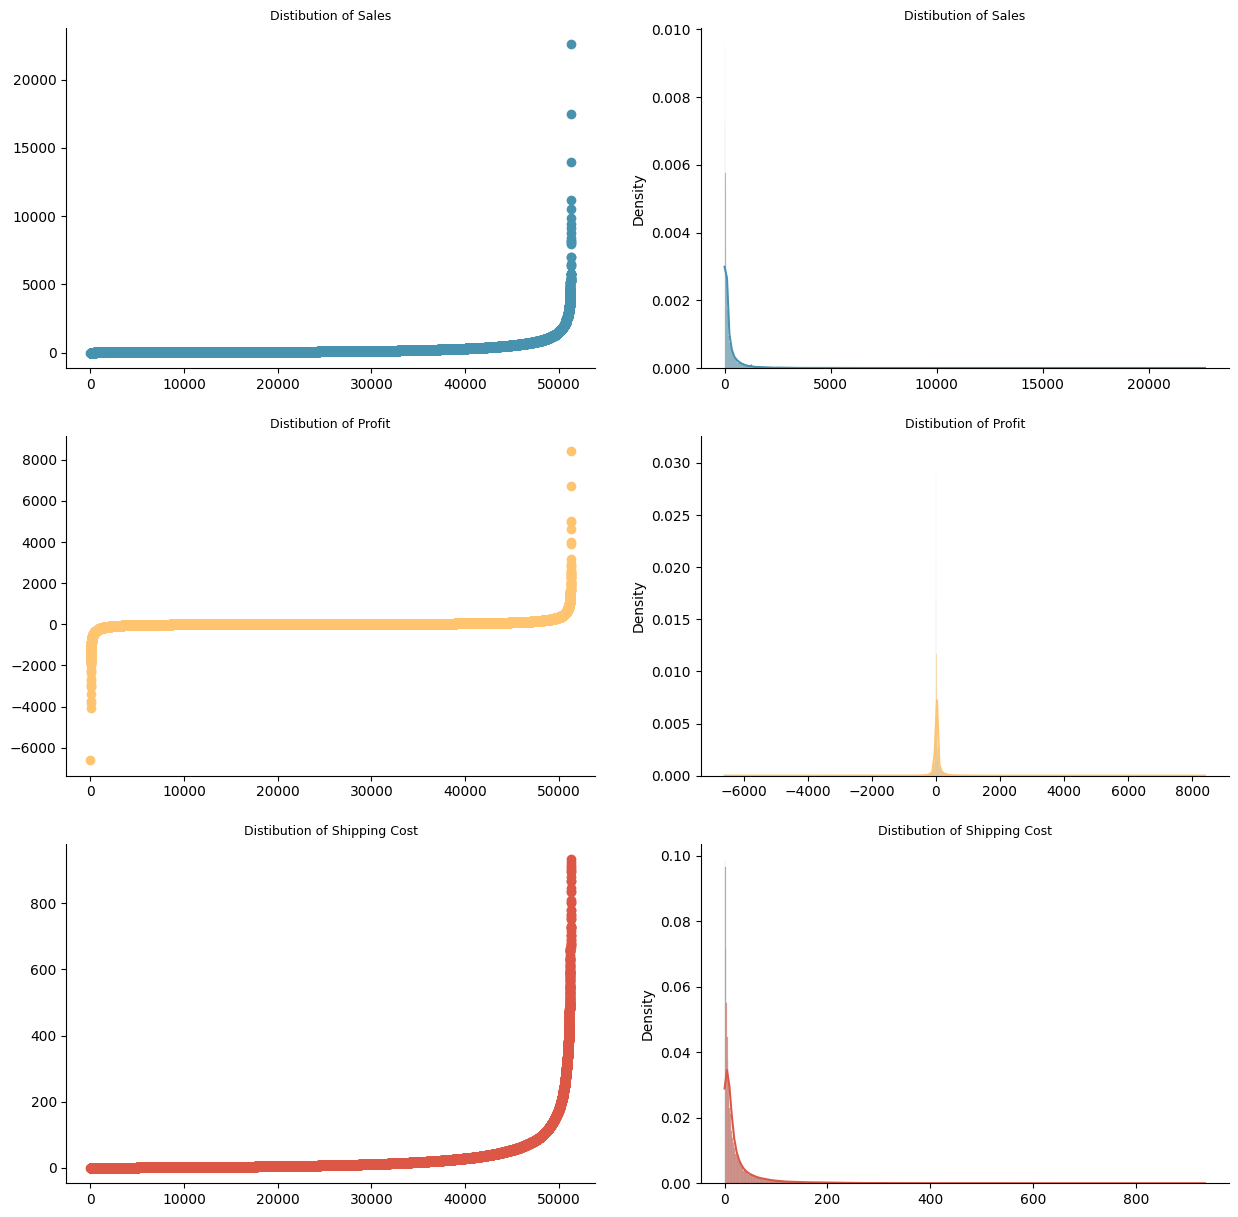

In [ ]:
n_rows = len(columns_to_observe)
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for i in range(n_cols):
  if i == 0:
    for j in range(n_rows):
        axes[j, i].scatter(range(df.shape[0]), np.sort(df[columns_to_observe[j]].values), color=colors[j])
        axes[j, i].set_title(f'Distibution of {columns_to_observe[j]}', fontsize=9)
  else:
    for j in range(n_rows):
        sns.histplot(df[columns_to_observe[j]], ax=axes[j, i], kde=True, stat='density',color=colors[j])
        axes[j, i].set_title(f'Distibution of {columns_to_observe[j]}', fontsize=9)
        axes[j, i].set(xlabel=None)
        sns.despine()


**Skewness** is the degree of asymmetry observed in a probability distribution. In the table below, we can see how significantly skewed data is.

**Kurtosis** is a measure of the tailedness of a distribution. We can see in the graphs and by the Kurtosis that we have Leptokurtic distribution: sharp peak with heavy tails. This indicates a higher concentration of extreme values or outliers in tails.



In [ ]:
table = pd.DataFrame(data={
    'Skewness': [df[column].skew() for column in columns_to_observe],
     'Kurtosis': [df[column].kurt() for column in columns_to_observe]}
                     , index=columns_to_observe)

table.style \
  .format(precision=3, thousands=".", decimal=",")

,Skewness,Kurtosis
Sales,"8,138","176,731"
Profit,"4,157","291,411"
Shipping Cost,"5,863","50,020"


Global Superstore's Sales, Profit and Shipping cost are far from a normal distriburion. Sales and Shipping cost are left-skewed or positive-skewed, Profit has two-tails with extreme high and low values (however, positive tail is longer that the negative).


## Isolation Forest
Isolation Forest is a machine learning algorithm that detects outliers in a dataset. It calculates the anomaly score for each data point using the Isolation Forest algorithm, which is based on the principle that outliers are data points that differ significantly from the majority of the data.

solation Forest is a tree-based machine learning model. In this model, partitions are generated by first randomly selecting a feature from the dataset and then selecting a split value that lies between the minimum and maximum values of the selected feature in a random manner.


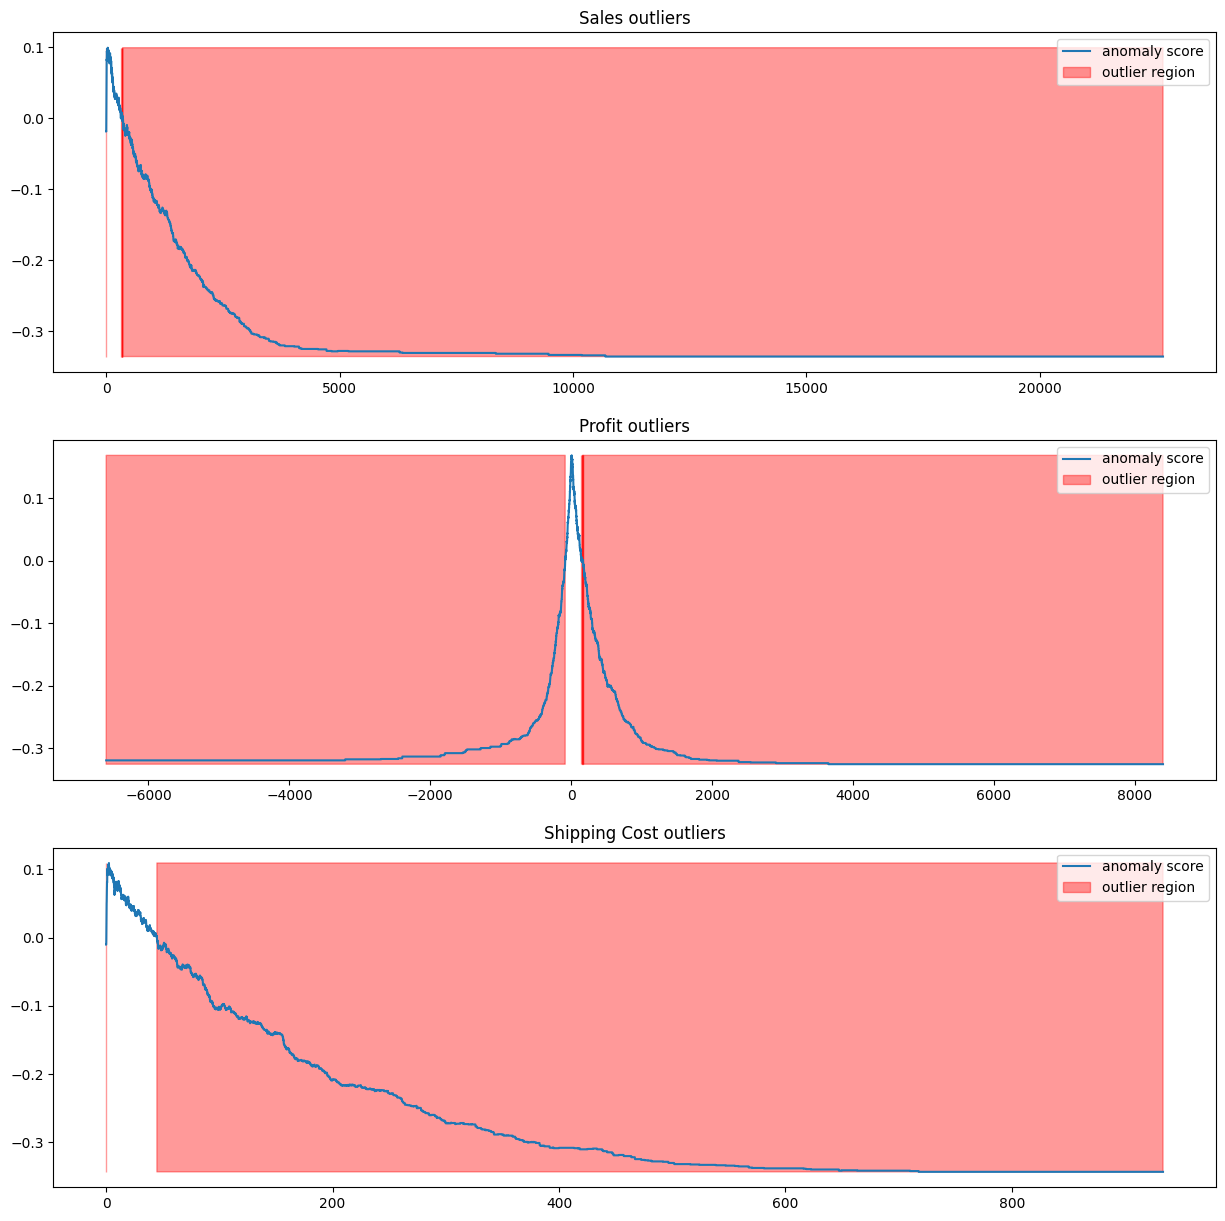

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 15))

for i in range(len(columns_to_observe)):
  isolation_forest = IsolationForest(n_estimators=100)
  isolation_forest.fit(df[columns_to_observe[i]].values.reshape(-1, 1))
  table = np.linspace(df[columns_to_observe[i]].min(), df[columns_to_observe[i]].max(), len(df)).reshape(-1,1)
  anomaly_score = isolation_forest.decision_function(table)
  outlier = isolation_forest.predict(table)
  ax[i].plot(table, anomaly_score, label='anomaly score')
  ax[i].fill_between(table.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
  ax[i].set_title(f'{columns_to_observe[i]} outliers')
  ax[i].legend()

plt.show()

The above figures demonstrate the anomaly scores and highlight the areas where outliers occur. As anticipated, the anomaly score mirrors the shape of the underlying distribution, and the outlier areas correspond to regions with low probability.

However, univariate analysis can only take us so far. It may be that some of the anomalies identified by our models do not correspond to the anomalies we expect. When dealing with multidimensional data as opposed to unidimensional data, approaches to anomaly detection become computationally more demanding and mathematically more complex.

# Multivariate Anomaly Detection

Most of the analyses that we conduct are multivariate in nature, due to the complexity of the world in which we live. In multivariate outlier detection, an outlier is defined as a combination of unusual scores on at least two variables.

So, using two pairs the Sales and Profit variables and the Shipping cost and Profit variables, we'll build an unsupervised multivariate anomaly detection method based on several models.

We're using [PyOD](https://pyod.readthedocs.io/en/latest/#) which is a Python library for detecting anomalies in multivariate data.

## Sales & Profit

It is expected that sales and profit are positively correlated, but as you can see from the data below, some of the points are outliers, which contradicts our expectations. Therefore, we need to investigate this further.

With PyOd library we'll implement 4 models to visualize outliers and inliers in our data:
* Cluster-based local outlier factor (CBLOF)
* Histogram-based outlier detection (HBOS)
* Isolation Forrest
* K-nearest neighbours

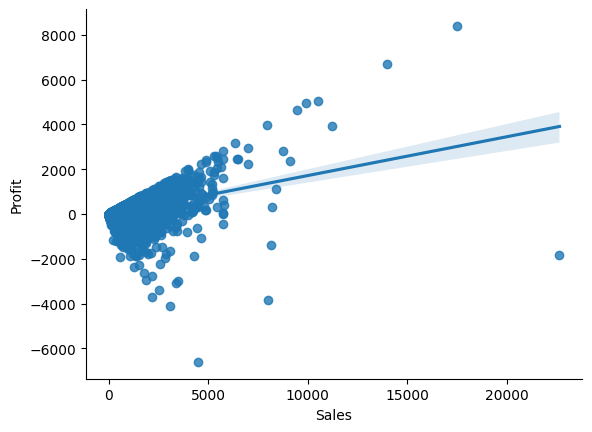

In [ ]:
sns.regplot(x='Sales', y='Profit', data=df)
sns.despine()

### Cluster-based Local Outlier Factor (CBLOF)
The CBLOF calculates the outlier score based on cluster-based local outlier factor. An anomaly score is computed by the distance of each instance to its cluster center multiplied by the instances belonging to its cluster. PyOD library includes the CBLOF implementation.


In [ ]:
scaler = MinMaxScaler()

cols_sales_profit = ['Sales', 'Profit']
outliers_fraction = 0.01

df_col = df[cols_sales_profit]
scaled_values = scaler.fit_transform(df_col)
df_scaled_sales_profit = pd.DataFrame(scaled_values, columns=df_col.columns)
df_scaled_sales_profit.index = df['Row ID']

In [ ]:
def anomaly_detection_model_CBLOF_implementation (df_scaled,
                                                  two_cols,
                                                  outliers_fraction):
  '''dataframe with scaled values,
  then implement Cluster-based Local Outlier Factor model from PyOd library.
  Returns DataFrame with cols and new outlier column.
  Plots graph with visible outliers and inliers'''

  # fitting model and getting scores
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  clf = CBLOF(contamination=outliers_fraction, check_estimator=False,
            random_state=42)
  clf.fit(scaled_values)
  scores_pred = clf.decision_function(scaled_values) * -1
  y_pred = clf.predict(scaled_values)

  # printing number of outliers and inliers
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  print(f'Number of OUTLIERS: {n_outliers}, number of INLIERS: {n_inliers}')

  df_scaled['outlier_CBLOF'] = y_pred.tolist()

  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_CBLOF'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_CBLOF'] == 0]).reshape(-1,1)

  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_CBLOF'] == 1]).reshape(-1,1)
  outliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_CBLOF'] == 1]).reshape(-1,1)

  # learned desicion function
  threshold = percentile(scores_pred, 100 * outliers_fraction)
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)

  # plotting graph
  plt.figure(figsize=(8, 8))
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

  a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
  handles_unfilled, labels = a.legend_elements()

  b = plt.scatter(inliers_sales, inliers_profit, c='white', s=20, edgecolor='k')
  c = plt.scatter(outliers_sales, outliers_profit, c='black', s=20, edgecolor='k')

  plt.axis('tight')
  plt.legend([handles_unfilled[0], b, c], ['Learned decision function',
                                           'Inliers',
                                           'Outliers'], loc='lower right')
  plt.title('Cluster-based Local Outlier Factor (CBLOF)')
  plt.show()

Number of OUTLIERS: 513, number of INLIERS: 50777


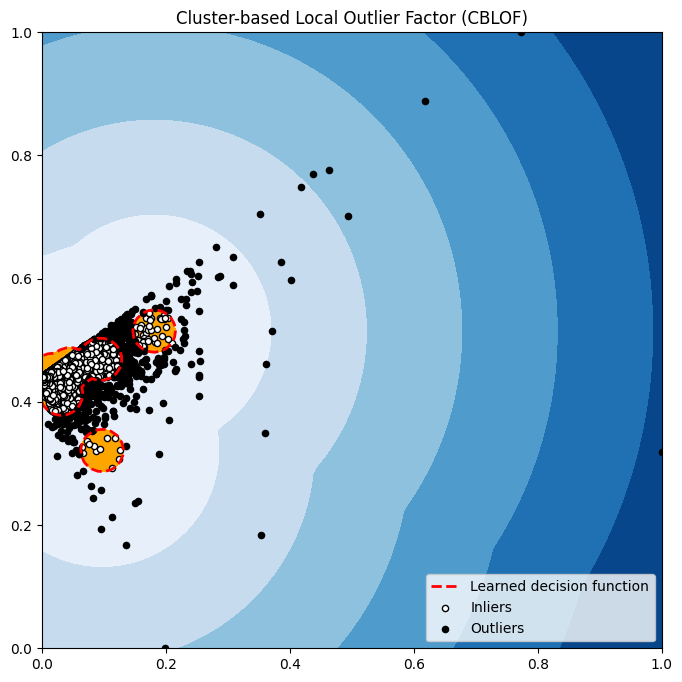

In [ ]:
anomaly_detection_model_CBLOF_implementation(df_scaled_sales_profit,
                                            cols_sales_profit,
                                            outliers_fraction)

### Histogram-based Outlier Detection (HBOS)
HBOS assumes the feature independence and calculates the degree of anomalies by building histograms. In multivariate anomaly detection, a histogram for each single feature can be computed, scored individually and combined at the end. When using PyOD library, the code are very similar with the CBLOF.

In [ ]:
def anomaly_detection_model_HBOS_implementation (df_scaled,
                                                 two_cols,
                                                 outliers_fraction):
  '''Takes cols (list with two column's names) from df and scale them,
  then implement Histogram-based Outlier Detection model from PyOd library.
  Returns DataFrame with cols and new oulier column.
  Plots graph with visible outliers and inliers'''

  # fitting model and getting scores
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  clf = HBOS(contamination=outliers_fraction)
  clf.fit(scaled_values)
  scores_pred = clf.decision_function(scaled_values) * -1
  y_pred = clf.predict(scaled_values)

  # printing number of outliers and inliers
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  print(f'Number of OUTLIERS: {n_outliers}, number of INLIERS: {n_inliers}')

  df_scaled['outlier_HBOS'] = y_pred.tolist()

  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_HBOS'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_HBOS'] == 0]).reshape(-1,1)

  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_HBOS'] == 1]).reshape(-1,1)
  outliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_HBOS'] == 1]).reshape(-1,1)

  # learned desicion function
  threshold = percentile(scores_pred, 100 * outliers_fraction)
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)

  # plotting graph
  plt.figure(figsize=(8, 8))
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

  a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
  handles_unfilled, labels = a.legend_elements()

  b = plt.scatter(inliers_sales, inliers_profit, c='white', s=20, edgecolor='k')
  c = plt.scatter(outliers_sales, outliers_profit, c='black', s=20, edgecolor='k')

  plt.axis('tight')
  plt.legend([handles_unfilled[0], b, c], ['Learned decision function', 'Inliers', 'Outliers'], loc='lower right')
  plt.title('Histogram-base Outlier Detection (HBOS)')
  plt.show()

Number of OUTLIERS: 417, number of INLIERS: 50873


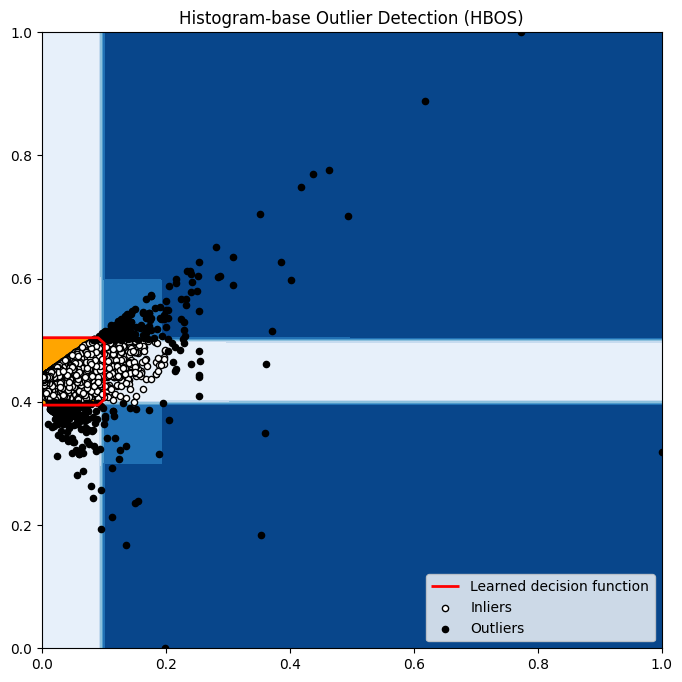

In [ ]:
anomaly_detection_model_HBOS_implementation (df_scaled_sales_profit,
                                             cols_sales_profit,
                                             outliers_fraction)

### Isolation Forest
Isolation Forest is similar in principle to Random Forest and is built on the basis of decision trees. Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that selected feature.

The PyOD Isolation Forest module is a wrapper of Scikit-learn Isolation Forest with more functionalities.

In [ ]:
def anomaly_detection_model_IForrest_implementation (df_scaled, two_cols, outliers_fraction):
  '''Takes cols (list with two column's names) from df and scale them,
  then implement Isolation Forrest model from PyOd library.
  Returns DataFrame with cols and new oulier column.
  Plots graph with visible outliers and inliers'''
  # fitting model and getting scores
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  clf = IForest(contamination=outliers_fraction,random_state=42)
  clf.fit(scaled_values)
  scores_pred = clf.decision_function(scaled_values) * -1
  y_pred = clf.predict(scaled_values)

  # printing number of outliers and inliers
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  print(f'Number of OUTLIERS: {n_outliers}, number of INLIERS: {n_inliers}')

  df_scaled['outlier_IForrest'] = y_pred.tolist()

  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_IForrest'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_IForrest'] == 0]).reshape(-1,1)

  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_IForrest'] == 1]).reshape(-1,1)
  outliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_IForrest'] == 1]).reshape(-1,1)

  # learned desicion function
  threshold = percentile(scores_pred, 100 * outliers_fraction)
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)

  # plotting graph
  plt.figure(figsize=(8, 8))
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

  a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
  handles_unfilled, labels = a.legend_elements()

  b = plt.scatter(inliers_sales, inliers_profit, c='white', s=20, edgecolor='k')
  c = plt.scatter(outliers_sales, outliers_profit, c='black', s=20, edgecolor='k')

  plt.axis('tight')
  plt.legend([handles_unfilled[0], b, c], ['Learned decision function',
                                           'Inliers', 'Outliers'], loc='lower right')
  plt.title('Isolation Forest')
  plt.show()


Number of OUTLIERS: 513, number of INLIERS: 50777


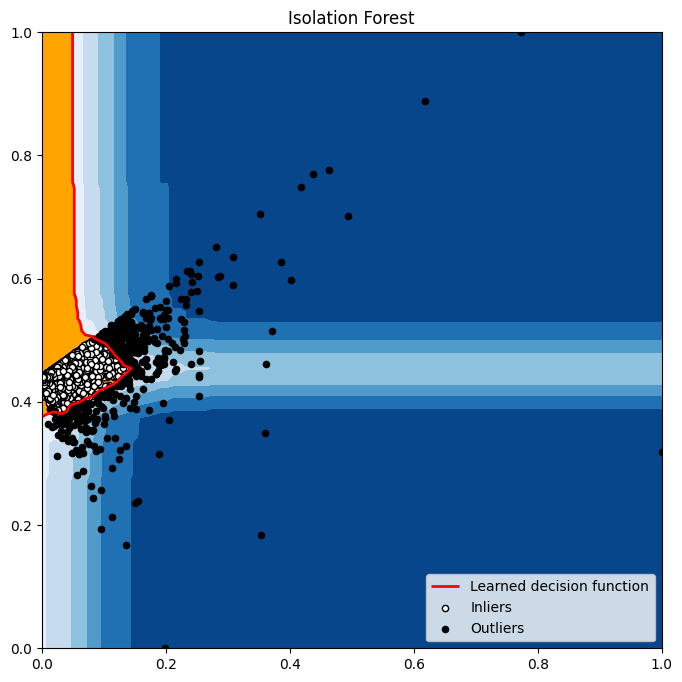

In [ ]:
anomaly_detection_model_IForrest_implementation(df_scaled_sales_profit,
                                                 cols_sales_profit,
                                                 outliers_fraction)

### K-Nearest Neighbours (KNN)
KNN is one of the simplest methods in anomaly detection. For a data point, its distance to its kth nearest neighbor could be viewed as the outlier score.



In [ ]:
def anomaly_detection_model_KNN_implementation (df_scaled,
                                                two_cols,
                                                outliers_fraction):
  '''Takes cols (list with two column's names) from df and scale them,
  then implement K - Nearest Neighbors model from PyOd library.
  Returns DataFrame with cols and new oulier column.
  Plots graph with visible outliers and inliers'''

  # fitting model and getting scores
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  clf = KNN(contamination=outliers_fraction)
  clf.fit(scaled_values)
  scores_pred = clf.decision_function(scaled_values) * -1
  y_pred = clf.predict(scaled_values)

  # printing number of outliers and inliers
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  print(f'Number of OUTLIERS: {n_outliers}, number of INLIERS: {n_inliers}')

  df_scaled['outlier_KNN'] = y_pred.tolist()

  # sales - inlier feature 1,  profit - inlier feature 2
  inliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_KNN'] == 0]).reshape(-1,1)
  inliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_KNN'] == 0]).reshape(-1,1)

  # sales - outlier feature 1, profit - outlier feature 2
  outliers_sales = np.array(df_scaled[two_cols[0]][df_scaled['outlier_KNN'] == 1]).reshape(-1,1)
  outliers_profit = np.array(df_scaled[two_cols[1]][df_scaled['outlier_KNN'] == 1]).reshape(-1,1)

  # learned desicion function
  threshold = percentile(scores_pred, 100 * outliers_fraction)
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)

  # plotting graph
  plt.figure(figsize=(8, 8))
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

  a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
  handles_unfilled, labels = a.legend_elements()

  b = plt.scatter(inliers_sales, inliers_profit, c='white', s=20, edgecolor='k')
  c = plt.scatter(outliers_sales, outliers_profit, c='black', s=20, edgecolor='k')

  plt.axis('tight')
  plt.legend([handles_unfilled[0], b, c], ['Learned decision function',
                                           'Inliers', 'Outliers'], loc='lower right')
  plt.title('K Nearest Neighbors (KNN)')
  plt.show()

Number of OUTLIERS: 443, number of INLIERS: 50847


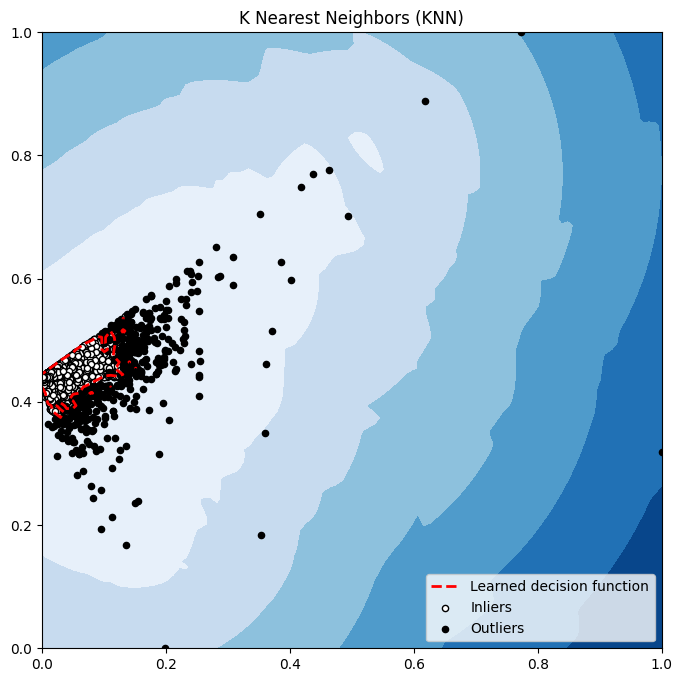

In [ ]:
anomaly_detection_model_KNN_implementation(df_scaled_sales_profit,
                                           cols_sales_profit,
                                           outliers_fraction)

### Inference
The anomalies predicted by the above four algorithms were not very different.

We got:
* 513 outliers via CBLOF
* 417 outliers via HBOS
* 513 outliers vis IForrest
* 443 outliets vis KNN

Total lines from the original dataframe, which all models marked as an outlier: **219**. Interestingly, the number of observations that were identified as outliers by all models combined is more than twice as low as for each individual model. This suggests that when analyzing outliers, it may be beneficial to use more than one modeling approach and to select models based on the data being analyzed.

We may want to investigate each of the outliers that determined by our model, for example, let’s look in details for a couple of outliers that determined by KNN, and try to understand what make them anomalies.

In [ ]:
# list of indexes in our main dataframe where all models got outlier
indexes_outliers = df_scaled_sales_profit.index[(df_scaled_sales_profit['outlier_CBLOF'] == 1) & (df_scaled_sales_profit['outlier_HBOS'] == 1) &\
                             (df_scaled_sales_profit['outlier_IForrest'] == 1) & (df_scaled_sales_profit['outlier_KNN'] == 1)].to_list()

In [ ]:
df[df['Row ID'].isin(indexes_outliers)].iloc[0]

Row ID                                        25330
Order ID                              IN-2013-71249
Order Date                      2013-10-17 00:00:00
Ship Date                       2013-10-18 00:00:00
Ship Mode                               First Class
Customer ID                                CR-12730
Customer Name                          Craig Reiter
Segment                                    Consumer
City                                       Brisbane
State                                    Queensland
Country                                   Australia
Postal Code                                     NaN
Market                                         APAC
Region                                      Oceania
Product ID                          TEC-PH-10004664
Category                                 Technology
Sub-Category                                 Phones
Product Name      Nokia Smart Phone, with Caller ID
Sales                                      5175.171
Quantity    

Here company's profit only 17%, even though discount is low.

In [ ]:
df[df['Row ID'].isin(indexes_outliers)].iloc[175]

Row ID                                                        38577
Order ID                                             CA-2012-162782
Order Date                                      2012-02-21 00:00:00
Ship Date                                       2012-02-27 00:00:00
Ship Mode                                            Standard Class
Customer ID                                                PW-19240
Customer Name                                          Pierre Wener
Segment                                                    Consumer
City                                                       Columbia
State                                                      Maryland
Country                                               United States
Postal Code                                                 21044.0
Market                                                           US
Region                                                         East
Product ID                                      

In this case, we have opposite situation where the profit is almost 50% of the sales.

We conducted a study of outliers in sales and profit data and identified at least 219 instances of emissions that need to be removed for further analysis (e.g., classification of buyers), in order to prevent the results of our models from being distorted and inaccurate. Many of these models are sensitive to these emissions and could produce incorrect results if they are included in the analysis.

## Shipping cost & Profit

We have a suggestion that these columns are negatively correlated - with higher shipping costs, lower profits. The graph below shows cases of the opposite situation, therefore, as with `sales` and `profit`, we will analyze using four models.

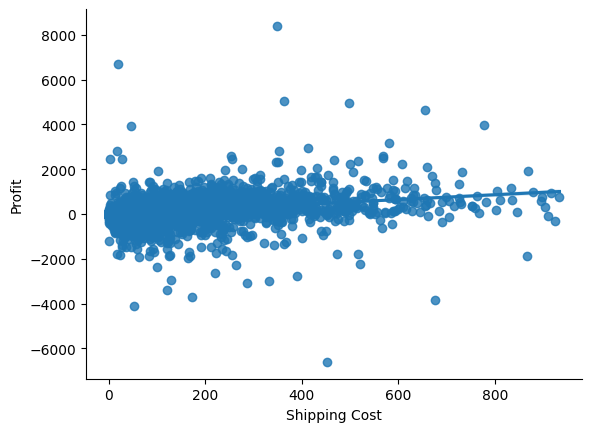

In [ ]:
sns.regplot(x='Shipping Cost', y='Profit', data=df)
sns.despine()

### Cluster-based Local Outlier Factor (CBLOF)


In [ ]:
cols_ship_cost_profit = ['Shipping Cost', 'Profit']

df_col = df[cols_ship_cost_profit]
scaled_values = scaler.fit_transform(df_col)
df_scaled_ship_cost_profit = pd.DataFrame(scaled_values, columns=df_col.columns)
df_scaled_ship_cost_profit.index = df['Row ID']

Number of OUTLIERS: 513, number of INLIERS: 50777


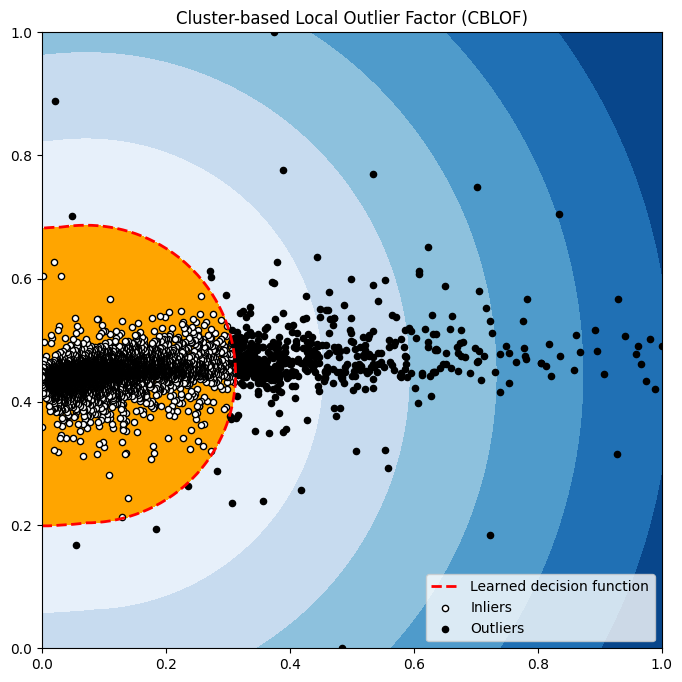

In [ ]:
anomaly_detection_model_CBLOF_implementation(df_scaled_ship_cost_profit,
                                             cols_ship_cost_profit,
                                             outliers_fraction)

### Histogram-based Outlier Detection (HBOS)

Number of OUTLIERS: 498, number of INLIERS: 50792


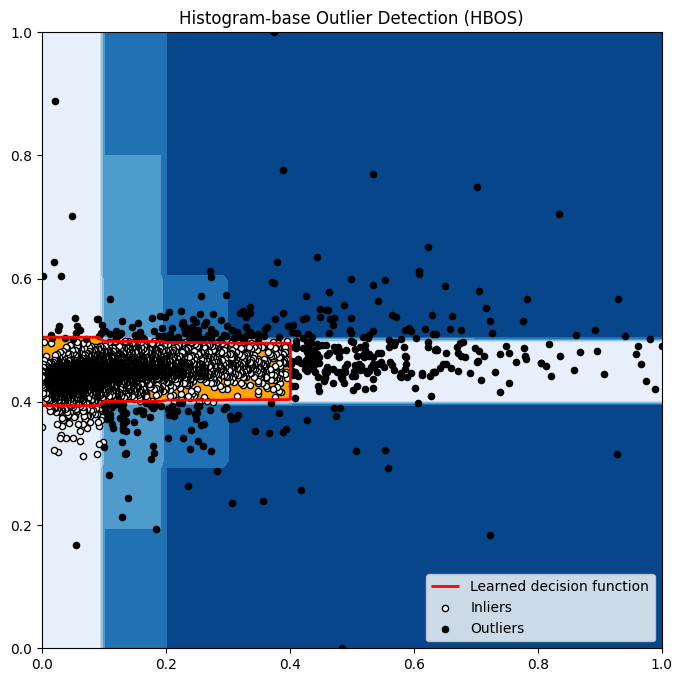

In [ ]:
anomaly_detection_model_HBOS_implementation(df_scaled_ship_cost_profit,
                                            cols_ship_cost_profit,
                                            outliers_fraction)

### Isolation Forest

Number of OUTLIERS: 513, number of INLIERS: 50777


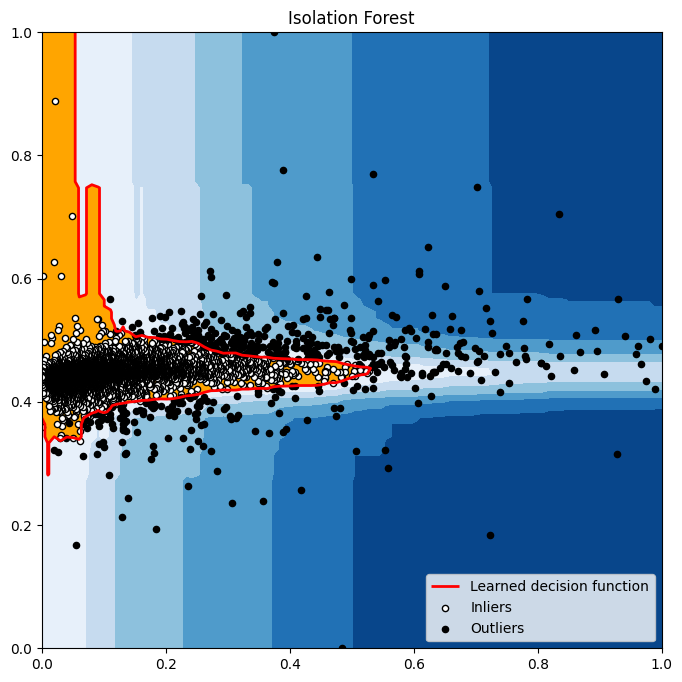

In [ ]:
anomaly_detection_model_IForrest_implementation(df_scaled_ship_cost_profit,
                                                cols_ship_cost_profit,
                                                outliers_fraction)

### K-Nearest Neighbours (KNN)

Number of OUTLIERS: 447, number of INLIERS: 50843


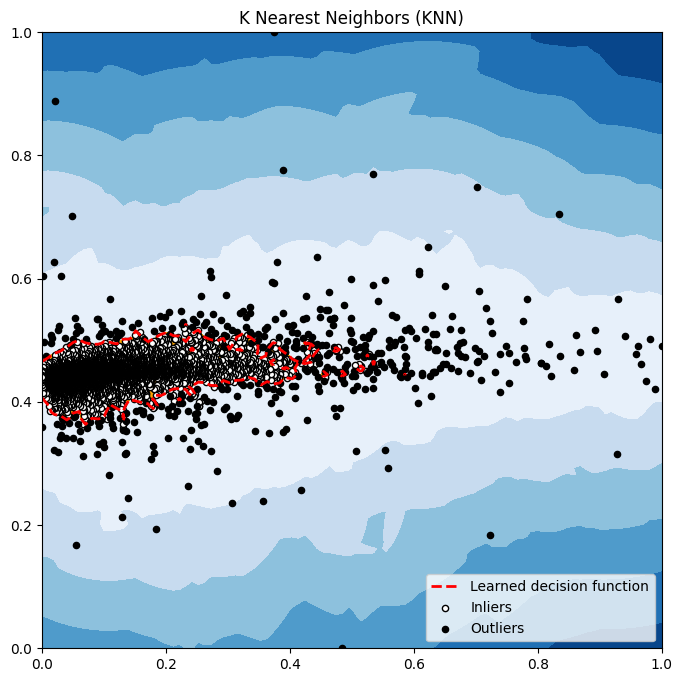

In [ ]:
anomaly_detection_model_KNN_implementation(df_scaled_ship_cost_profit,
                                           cols_ship_cost_profit,
                                           outliers_fraction)

### Inference
As with Sales and Profit, the anomalies predicted by all four algorithms were not much different.

We got:
* 513 outliers via CBLOF
* 498 outliers via HBOS
* 513 outliers vis IForrest
* 447 outliets vis KNN

**243** orders were marked as outliers by all models. The situation is the same as in the analysis of sales and profits - the results overlap only in half of the cases.

Let's examine couple of outliers.

In [ ]:
# list of indexes in our main dataframe where all models got outlier
indexes_outliers_ship_cost = df_scaled_ship_cost_profit.index[(df_scaled_ship_cost_profit['outlier_CBLOF'] == 1) & (df_scaled_ship_cost_profit['outlier_HBOS'] == 1) &\
                             (df_scaled_ship_cost_profit['outlier_IForrest'] == 1) & (df_scaled_ship_cost_profit['outlier_KNN'] == 1)].to_list()

In [ ]:
df[df['Row ID'].isin(indexes_outliers_ship_cost)].iloc[0]

Row ID                                                        32298
Order ID                                             CA-2012-124891
Order Date                                      2012-07-31 00:00:00
Ship Date                                       2012-07-31 00:00:00
Ship Mode                                                  Same Day
Customer ID                                                RH-19495
Customer Name                                           Rick Hansen
Segment                                                    Consumer
City                                                  New York City
State                                                      New York
Country                                               United States
Postal Code                                                 10024.0
Market                                                           US
Region                                                         East
Product ID                                      

In this case, the shipping cost is more than our profit.

In [ ]:
df[df['Row ID'].isin(indexes_outliers_ship_cost)].iloc[99]

Row ID                                          18307
Order ID                              ES-2013-3903130
Order Date                        2013-09-03 00:00:00
Ship Date                         2013-09-05 00:00:00
Ship Mode                                Second Class
Customer ID                                  MZ-17335
Customer Name                           Maria Zettner
Segment                                   Home Office
City                                         Malakoff
State                                   Ile-de-France
Country                                        France
Postal Code                                       NaN
Market                                             EU
Region                                        Central
Product ID                            OFF-AP-10002904
Category                              Office Supplies
Sub-Category                               Appliances
Product Name      Hamilton Beach Refrigerator, Silver
Sales                       

Here profit is only 6% of the shipping cost.

In [ ]:
df[df['Row ID'].isin(indexes_outliers_ship_cost)].iloc[170]

Row ID                                    15922
Order ID                        ES-2013-1692384
Order Date                  2013-11-28 00:00:00
Ship Date                   2013-12-04 00:00:00
Ship Mode                        Standard Class
Customer ID                            RB-19570
Customer Name                       Rob Beeghly
Segment                                Consumer
City                                  Barakaldo
State                            Basque Country
Country                                   Spain
Postal Code                                 NaN
Market                                       EU
Region                                    South
Product ID                      FUR-BO-10004999
Category                              Furniture
Sub-Category                          Bookcases
Product Name      Safco Classic Bookcase, Metal
Sales                                   3063.27
Quantity                                      7
Discount                                

In this instance shippping cost is lower than profit - shipping cost is about 29% of the profit.

We will also look at how many orders were marked as outliers by both the sales and profit data set, and the shipping price and profit.


We got 84 lines that need to be deleted for further analysis.

In [ ]:
index_list =list(set(indexes_outliers_ship_cost) & set(indexes_outliers))

In [ ]:
len(df[df['Row ID'].isin(index_list)])

84

# Conclusion

The aim of this project has been achieved. We examined outliers in the data using multivariate analysis, and also visualized all outliers abd inliers and examine individual cases of outliers.

inspo: https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1